# Data Pre-Processing

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import PIL


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12401049929655360781
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4155965440
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17156954172648801779
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [3]:
# initializing train and test lists

x_train, y_train, x_test, y_test= [], [], [], []

In [4]:
# loading data

faces_dir= 'att_faces/'

sub_f= sorted([f.path for f in os.scandir(faces_dir) if f.is_dir()])

In [5]:
from tensorflow.keras.preprocessing.image import  load_img, img_to_array
from tensorflow.keras.preprocessing import image

In [6]:
# loading data into list vars
from PIL import Image


for subject_id, folders in enumerate(sub_f):
    for file in sorted(os.listdir(folders)):
        img= load_img(folders+ '/' +file, color_mode= 'grayscale')
        img= img_to_array(img.resize((120,120))).astype('float32')/255
        if subject_id <41:
            x_train.append(img)
            y_train.append(subject_id)
        else:
            x_test.append(img)
            y_test.append(subject_id-41)

In [7]:
# images --> array
x_train= np.array(x_train)
y_train= np.array(y_train)

x_test= np.array(x_test)
y_test= np.array(y_test)

In [8]:
x_train.shape

(412, 120, 120, 1)

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Input,Dropout
from tensorflow.keras.models import Sequential

## Designing the model

According to the SNN (Siamese Neural Net) architecture, only network is enough to create both the top and bottom instances. The reason being, that the single instance can be reused as the weights are to be shared.

In [10]:
def network(input_shape):
    model= Sequential()
    model.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu',
                     input_shape= input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(units=128, activation= 'sigmoid'))
    model.summary()
    return model

In [11]:
# taking the input shape
input_shape= x_train.shape[1:]

# instantiating the shared network
shared_net= network(input_shape)

# defining the top and bottom inputs
top_input= Input(shape= input_shape)
bottom_input= Input(shape= input_shape)

# defining the top and bottom outputs
top_output= shared_net(top_input)
bottom_output= shared_net(bottom_input)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 128)     1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 64)        73792     
_________________________________________________________________
dropout (Dropout)            (None, 57, 57, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 207936)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               26615936  
Total params: 26,691,008
Trainable params: 26,691,008
Non-trainable params: 0
____________________________________________

In [12]:
from tensorflow.keras import backend as k

# function to compute the euclidean distance
def euc_dist(vectors):
    vector1, vector2= vectors
    sum_of_squares= k.sum(k.square(vector1-vector2), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_of_squares, k.epsilon()))

### In the below code cell, we have used Lambda layer to define our own layer by wrapping an arbitary function as a Layer object.

In [13]:
from tensorflow.keras.layers import Lambda

# Euclidean function wrapped inside lambda layer
distance= Lambda(euc_dist, output_shape=(1,))([top_output, bottom_output])

In [14]:
# combining distance layer with the previously prepared top and bottom inputs

from tensorflow.keras.models import Model
model= Model( [top_input, bottom_input], outputs=distance)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 120, 120, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          26691008    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]             

# Training

In [16]:
import random

# creating pairs of araays of images with their labels

def create_pairs(X,Y, num_classes):
    pairs, labels = [], []
    # index of images in X and Y for each class
    class_idx = [np.where(Y==i)[0] for i in range(num_classes)]
    # The minimum number of images across all classes
    min_images = min(len(class_idx[i]) for i in range(num_classes)) - 1
    for c in range(num_classes):
        for n in range(min_images):
            # create positive pair
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[c][n+1]]
            pairs.append((img1, img2))
            labels.append(1)
      
            # create negative pair
            # first, create list of classes that are different from the current class
            neg_list = list(range(num_classes))
            neg_list.remove(c)
            # select a random class from the negative list. 
            # this class will be used to form the negative pair
            neg_c = random.sample(neg_list,1)[0]
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[neg_c][n]]
            pairs.append((img1,img2))
            labels.append(0)

    return np.array(pairs), np.array(labels)

        

In [17]:
num_classes= len(np.unique(y_train))
training_pairs, training_labels= create_pairs(x_train, y_train,
                                             num_classes)
test_pairs, test_labels= create_pairs(x_test, y_test, len(np.unique(y_test)))

# Defining the loss and accuracy

In [18]:
def contrastive_loss(y_true, D):
    margin = 1
    return k.mean(y_true * k.square(D) + (1 - y_true) * k.maximum((margin-D),0))

def accuracy(y_true, y_pred):
    return k.mean(k.equal(y_true, k.cast(y_pred < 0.6, y_true.dtype)))

In [19]:
# maintaining the same data type for bothe the input parameters
training_labels= k.cast(training_labels, training_pairs.dtype)

In [20]:
model.compile(loss= contrastive_loss, optimizer='adam', metrics= accuracy)
history=model.fit([training_pairs[:,0], training_pairs[:,1]], 
          training_labels,
                  batch_size=64, epochs=15)

Epoch 1/15
11/11 [==============================] - 16s 836ms/step - loss: 0.2165 - accuracy: 0.7940
Epoch 2/15
11/11 [==============================] - 3s 226ms/step - loss: 0.1203 - accuracy: 0.9119
Epoch 3/15
11/11 [==============================] - 2s 145ms/step - loss: 0.1051 - accuracy: 0.9347
Epoch 4/15
11/11 [==============================] - 2s 146ms/step - loss: 0.0823 - accuracy: 0.9588
Epoch 5/15
11/11 [==============================] - 2s 146ms/step - loss: 0.0642 - accuracy: 0.9773
Epoch 6/15
11/11 [==============================] - 2s 146ms/step - loss: 0.0543 - accuracy: 0.9801
Epoch 7/15
11/11 [==============================] - 2s 146ms/step - loss: 0.0444 - accuracy: 0.9957
Epoch 8/15
11/11 [==============================] - 2s 146ms/step - loss: 0.0393 - accuracy: 0.9972
Epoch 9/15
11/11 [==============================] - 2s 146ms/step - loss: 0.0307 - accuracy: 1.0000
Epoch 10/15
11/11 [==============================] - 2s 146ms/step - loss: 0.0305 - accuracy: 1.000

In [21]:
idx1, idx2= 1, 4
img1= np.expand_dims(x_test[idx1], axis=0)
img2= np.expand_dims(x_test[idx2], axis=0)

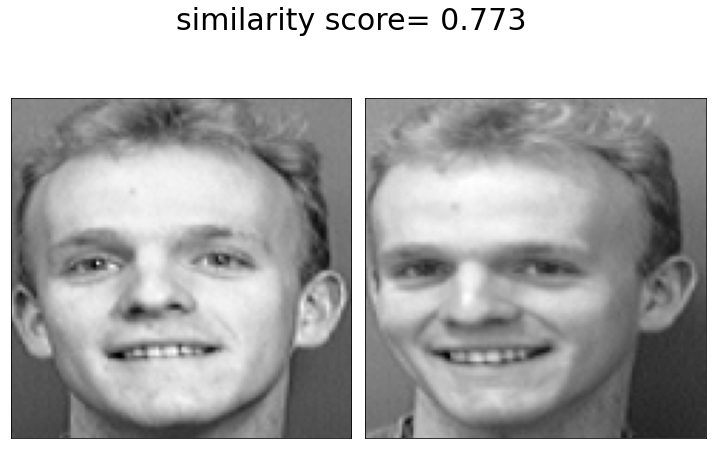

In [22]:
import matplotlib.pyplot as plt

fig, (ax1, ax2)= plt.subplots( 1, 2 , figsize=(10,7))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')
for ax in [ax1, ax2]:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
dissimilarity= model.predict([img1, img2])[0][0]
fig.suptitle('similarity score={: .3f} '.format(1- dissimilarity), size=30)
plt.tight_layout()
plt.show()

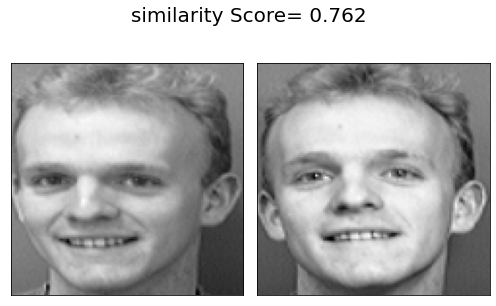

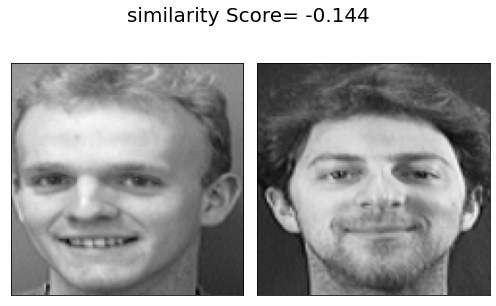

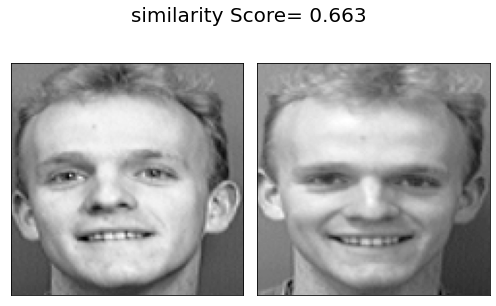

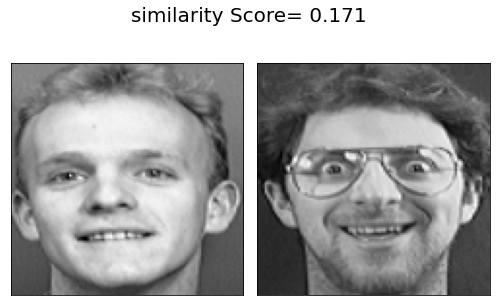

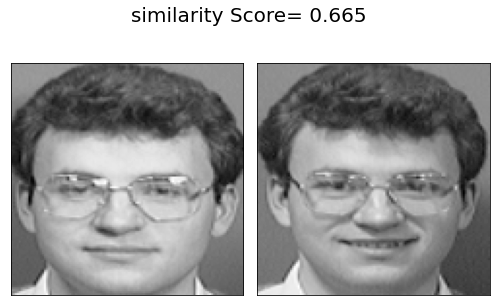

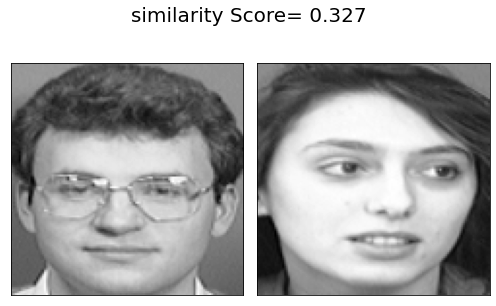

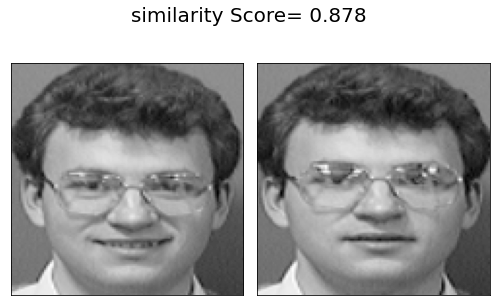

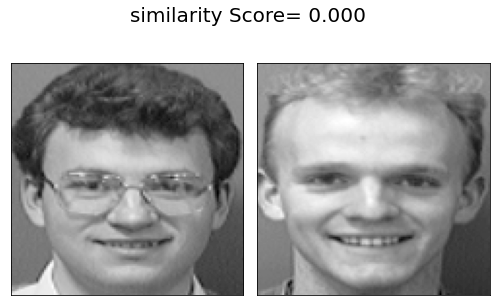

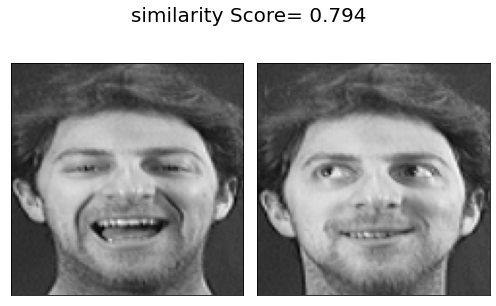

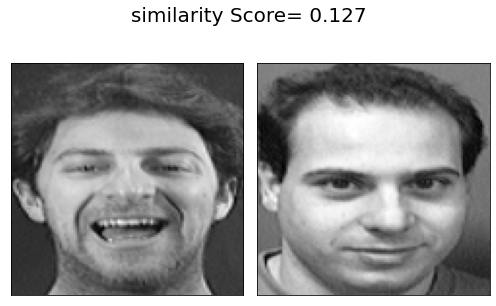

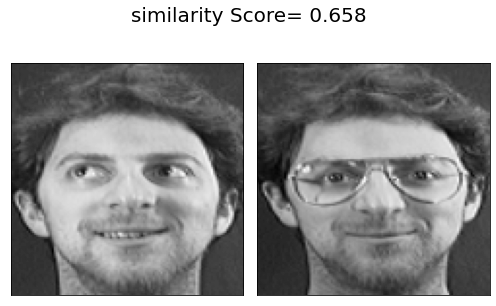

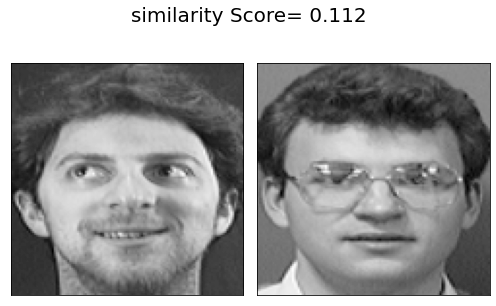

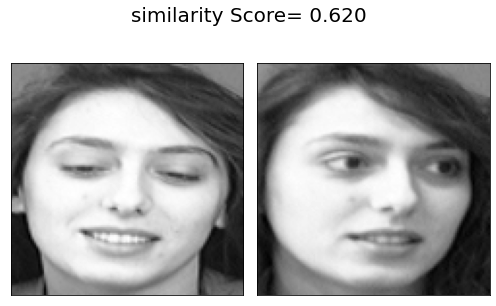

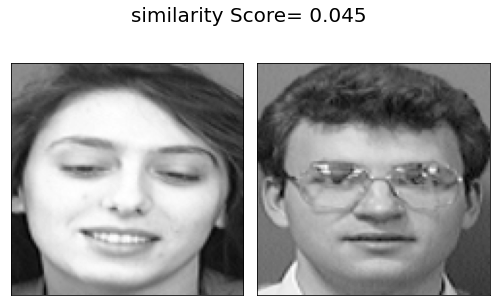

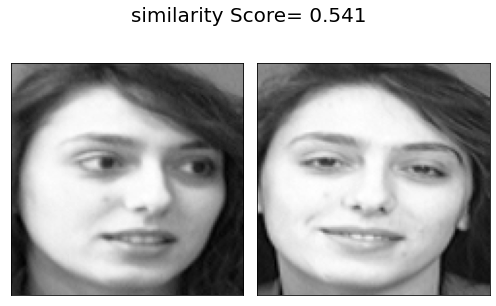

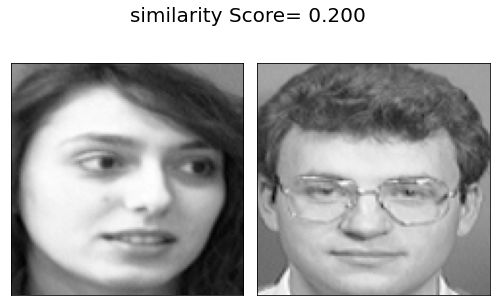

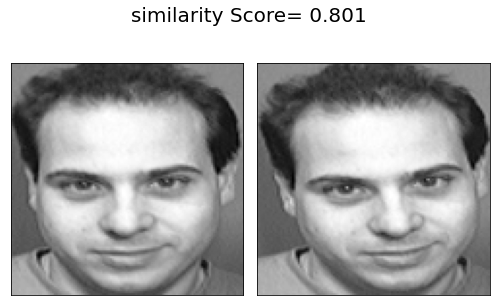

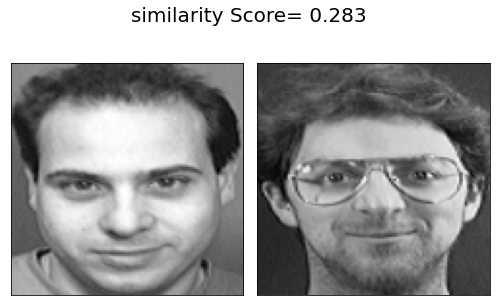

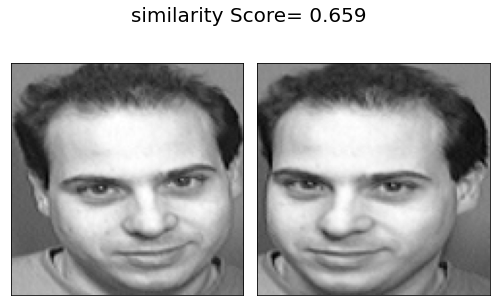

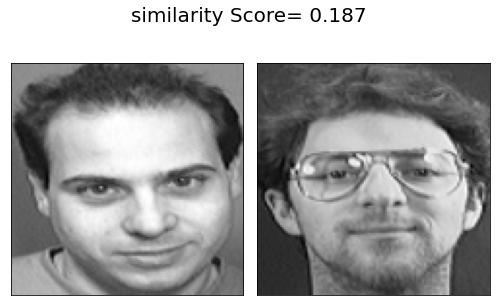

In [23]:
for i in range (5):
    for n in range (0,4):
        fig, (ax1, ax2)= plt.subplots(1,2, figsize=(7,5))
        img1= np.expand_dims(test_pairs[i*20 +n, 0], axis=0)
        img2= np.expand_dims(test_pairs[i*20+n, 1], axis=0)
        dissimilarity= model.predict([img1, img2])[0][0]
        img1, img2= np.squeeze(img1), np.squeeze(img2)
        ax1.imshow(img1, cmap='gray')
        ax2.imshow(img2, cmap='gray')
        
        for ax in [ax1, ax2]:
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        fig.suptitle('similarity Score= {:.3f}'.format(1-dissimilarity), size=20)
plt.show()

In [24]:
model.save('siamese_nn.h5')

In [25]:
# serialize model to JSON
model_json = model.to_json()

In [26]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [27]:
pred= model.predict([test_pairs[:, 0], test_pairs[:, 1]])

In [28]:
def get_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.50].mean()*100

In [29]:
get_accuracy(pred, test_labels)

91.48936170212765

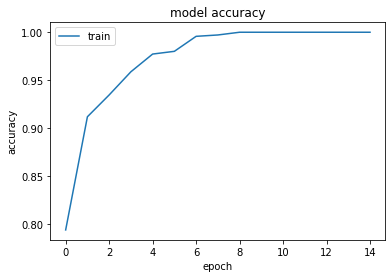

In [30]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

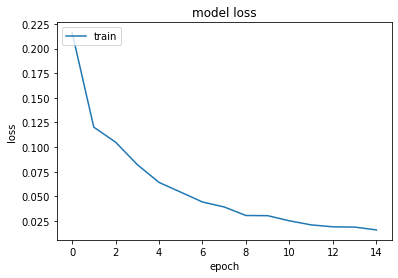

In [31]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Face Detection and Onboarding Process

In [44]:
import cv2
import os

In [45]:
 cascade= cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [46]:
def face_detection(img, draw_box=True):
    global x,y, w, h
    gray_img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    face= cascade.detectMultiScale(gray_img, scaleFactor=1.6)
    
    for (x, y, w, h) in face:
        if draw_box:
            cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 5)
        
    face_box= img[y:y+h, x:x+w]
        
    face_coords= [x, y, w, h]
        
    return img, face_box, face_coords    

## Image capture

In [47]:
import math
video_capture= cv2.VideoCapture(0)
video_capture.set(150,150)
def write_on_frame(frame, text, text_x, text_y):
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=2)[0]
    box_coords = ((text_x, text_y), (text_x+text_width+20, text_y-text_height-20))
    cv2.rectangle(frame, box_coords[0], box_coords[1], (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, text, (text_x, text_y-10), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
    return frame
name= input("Enter your name")
counter=10

while True:
    _, frame= video_capture.read()
    
    frame, face_box, face_coords= face_detection(frame)
    
    text= 'Image will be taken in{}...'. format(math.ceil(counter))
    
    if face_box is not None:
        frame= write_on_frame(frame, text, face_coords[0], face_coords[1]-10)
        
        cv2.imshow('Video', frame)
    
    cv2.waitKey(1)
    
    counter -= 0.1
    
    if counter <= 0:
        cv2.imwrite("detected/"+name+'.png', face_box)
        break

# Releasing the capture
video_capture.release()
cv2.destroyAllWindows()
print("Image Captured")

Enter your nameSai
Image Captured


# Face Recognition

In [48]:
import cv2

In [49]:
true_img= cv2.imread("detected/"+name+'.png',0)
true_img= true_img.astype('float32')/255
true_img= cv2.resize(true_img, (120, 120))
true_img= true_img.reshape(1, true_img.shape[0], true_img.shape[1], 1)


In [50]:
import collections

In [51]:
video_capture = cv2.VideoCapture(0)
preds = collections.deque(maxlen=15)

while True:
    # Capture frame-by-frame
    _, frame = video_capture.read()

    # Detect Faces
    frame, face_img, face_coords = face_detection(frame, draw_box=False)
  
    if face_img is not None:
        face_img = cv2.cvtColor(face_img,  cv2.COLOR_BGR2GRAY)
        face_img = face_img.astype('float32')/255
        face_img = cv2.resize(face_img, (120, 120))
        face_img = face_img.reshape(1, face_img.shape[0], face_img.shape[1], 1)
        preds.append(1-model.predict([true_img, face_img])[0][0])
        x,y,w,h = face_coords
        if len(preds) == 15 and sum(preds)/15 >= 0.6:
            text = "Identified :"+name+" "+str(math.floor(sum(preds)/15*100))+"%"
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 5)
        elif len(preds) < 15:
            text = "Identifying ..."
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 165, 255), 5)
        else:
            text = "Identity Unknown!"+str(math.floor(sum(preds)/15*100))+"%"
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 5)
        frame = write_on_frame(frame, text, face_coords[0], face_coords[1]-10)

    else:
        preds = collections.deque(maxlen=15) # clear existing predictions if no face detected 

    # Display the resulting frame
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

### Adding to DataBase

In [52]:
files= os.listdir('friends')

images= [file for file in files if 'jpg' in file]

for image in images:
    img= cv2.imread('friends/'+image)
    detected_faces, facebox, cords = face_detection(img)
    cv2.imwrite('detected/'+ image, facebox)

In [53]:
import math
video_capture= cv2.VideoCapture(0)
video_capture.set(150,150)
def write_on_frame(frame, text, text_x, text_y):
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=2)[0]
    box_coords = ((text_x, text_y), (text_x+text_width+20, text_y-text_height-20))
    cv2.rectangle(frame, box_coords[0], box_coords[1], (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, text, (text_x, text_y-10), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
    return frame
counter=10

while True:
    _, frame= video_capture.read()
    
    frame, face_box, face_coords= face_detection(frame)
    
    text= 'Image will be taken in{}...'. format(math.ceil(counter))
    
    if face_box is not None:
        frame= write_on_frame(frame, text, face_coords[0], face_coords[1]-10)
        
        cv2.imshow('Video', frame)
    
    cv2.waitKey(1)
    
    counter -= 0.1
    
    if counter <= 0:
        cv2.imwrite('Temp.png', face_box)
        break

# Releasing the capture
video_capture.release()
cv2.destroyAllWindows()
print("Image Captured")

Image Captured


In [54]:
face_img=load_img("Temp.png",color_mode= 'grayscale')
face_img=img_to_array(face_img.resize((120,120))).astype('float32')/255

In [55]:
preds=[]
d=dict()
for file in sorted(os.listdir("detected/")):
        img= load_img("detected/"+file, color_mode= 'grayscale')
        img= img_to_array(img.resize((120,120))).astype('float32')/255
        d[file]=1-model.predict([np.expand_dims(img,axis=0), np.expand_dims(face_img,axis=0)])[0][0]

if(max(d.values())<0.3):
    print("Unknown! Please retake pic")
else:
    print("Hey "+str(max(d,key=d.get).split('.')[0])+ " how is it going?")
    
        

Unknown! Please retake pic
